In [1]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
#import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
import datetime as datetime
#sys.path.insert(1, '../../functions')
#from ParticlePlotFunctions import *
import pickle
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# produce unbeaching map

Ufiles = '../../input/modelfields/MITgcm4km/RGEMS_2008_Surf.nc'
Xfiles = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'

date = 200

dfile = Dataset(Ufiles)
Uvel = dfile.variables['UVEL'][date,:,:]
Vvel = dfile.variables['VVEL'][date,:,:]
dfile = Dataset(Xfiles)
bathy = dfile.variables['maskC'][0,:,:]
XG = dfile.variables['XG'][:]
YG = dfile.variables['YG'][:]
XC = dfile.variables['XC'][:]
YC = dfile.variables['YC'][:]

unBeachU = np.zeros(Uvel.shape)
unBeachV = np.zeros(Vvel.shape)
for j in range(1, Uvel.shape[0]-2):
    for i in range(1, Uvel.shape[1]-2):
        if Uvel[j, i] == 0 and Uvel[j, i+1] == 0 and Vvel[j, i] == 0 and Vvel[j+1, i] == 0:
            if abs(Uvel[j, i-1]) > 1e-10:
                unBeachU[j, i] = -1
            if abs(Uvel[j, i+2]) > 1e-10:
                unBeachU[j, i+1] = 1
            if abs(Vvel[j-1, i]) > 1e-10:
                unBeachV[j, i] = -1
            if abs(Vvel[j+2, i]) > 1e-10:
                unBeachV[j+1, i] = 1

coordsU = {'XG': XG,
           'YC': YC}
dataArrayUnBeachU = xr.DataArray(unBeachU, name='unBeachU', coords=coordsU, dims=('YC', 'XG'))
coordsV = {'XC': XC,
           'YG': YG}
dataArrayUnBeachV = xr.DataArray(unBeachV, name='unBeachV', coords=coordsV, dims=('YG','XC'))

dataset = xr.Dataset()
dataset[dataArrayUnBeachU.name] = dataArrayUnBeachU
dataset[dataArrayUnBeachV.name] = dataArrayUnBeachV
dataset.to_netcdf('unbeachingUV.nc', engine='scipy')

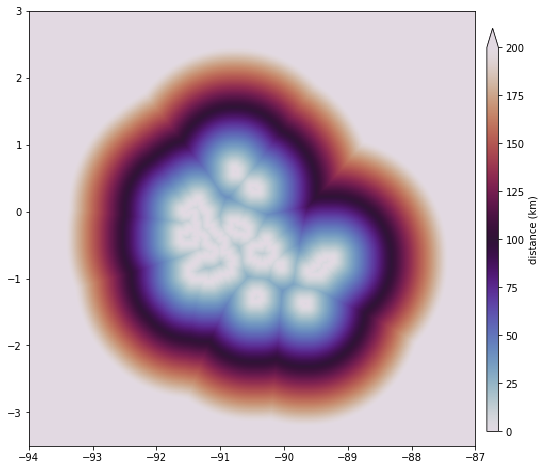

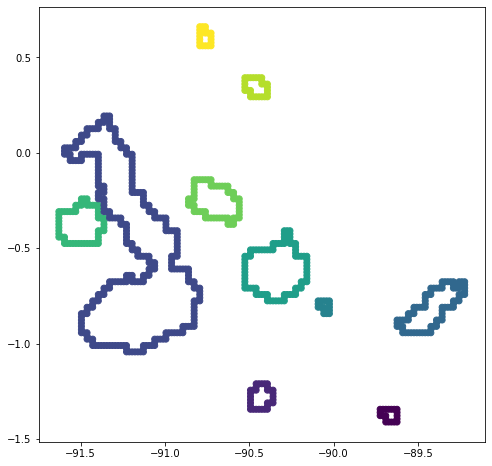

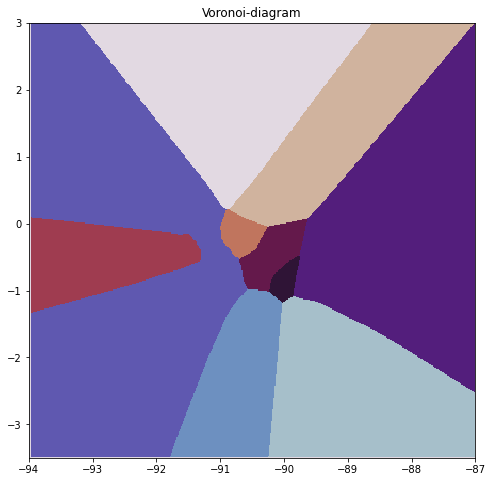

In [3]:
# produce distance map and seaborder map

def getclosest_ij(lats,lons,latpt,lonpt):    
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_lat = (lats-latpt)**2                      # find squared distance of every point on grid
    dist_lon = (lons-lonpt)**2
    minindex_lat = dist_lat.argmin()                # 1D index of minimum dist_sq element
    minindex_lon = dist_lon.argmin()
    return minindex_lat, minindex_lon                # Get 2D index for latvals and lonvals arrays from 1D index


def lonlatdistance(loc1,loc2):
    """Function to calculate distance between two lonlat points"""
    R = 6373.0
    lat1 = math.radians(loc1[1])
    lon1 = math.radians(loc1[0])
    lat2 = math.radians(loc2[1])
    lon2 = math.radians(loc2[0])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

####################################################################
# A] make a map that outlines all islands in 'double' the resolution
galapagos_domain = [-94, -87, -3.5, 3]
dfile = Dataset(Xfiles)
lon = dfile.variables['XC'][:]
lat = dfile.variables['YC'][:]
landmask = dfile.variables['maskC'][0,:,:]
iy_min, ix_min = getclosest_ij(lat, lon, galapagos_domain[2], galapagos_domain[0])
iy_max, ix_max = getclosest_ij(lat, lon, galapagos_domain[3], galapagos_domain[1])
bathy = landmask[iy_min:iy_max,ix_min:ix_max]

landborder = np.zeros((bathy.shape[0]*2,bathy.shape[1]*2))
for i in range(1,landborder.shape[0]-1):
    for j in range(1,landborder.shape[1]-1):
        if i%2==0 and j%2==1:
            if abs(bathy[int(i/2),int(j/2)]-bathy[int(i/2),int(j/2)+1])==1:
                landborder[i,j]=1
        if i%2==1 and j%2==0:
            if abs(bathy[int(i/2),int(j/2)]-bathy[int(i/2)+1,int(j/2)])==1:
                landborder[i,j]=1    
        if i%2==1 and j%2==1:
            landcorners = bathy[int(i/2),int(j/2)] + bathy[int(i/2)+1,int(j/2)] + bathy[int(i/2)+1,int(j/2)+1] + bathy[int(i/2),int(j/2)+1]
            if landcorners>0 and landcorners <4:
                landborder[i,j]=1

lon_high = np.linspace(XC[ix_min],XC[ix_max],landborder.shape[1],endpoint=True)
lat_high = np.linspace(YC[iy_min],YC[iy_max],landborder.shape[0],endpoint=True)             
land = np.where(landborder==1)


##################################################################
# B] Determine for each landpoint which island it is
# automate, so it works for any kind of data -> check for neighbouring landpoints

island = np.zeros(land[0][:].shape)
new_island = 1
for landpoints in range(1,len(land[0][:])): 
    if island[landpoints]==0: # new island   
        i = land[1][landpoints] # location of landmark
        j = land[0][landpoints]
        island[landpoints] = new_island 
        if landborder[j+1,i] == 1: #check where next landmark is, pick the one from north in clock-wise direction
            jnew = j+1
            inew = i
        elif landborder[j,i+1] == 1:
            inew = i+1
            jnew = j
        elif landborder[j-1,i] == 1:
            jnew = j-1
            inew = i
        elif landborder[j,i-1] == 1:
            inew = i-1
            jnew = j
        new_point = np.where((land[1][:] == inew) & (land[0][:] == jnew))[0][0]
        while new_point != landpoints: #while the next landmark is not assigned to an island yet
                island[new_point] = new_island
                if landborder[jnew+1,inew] == 1 and jnew+1 != j: 
                    j = jnew
                    i = inew
                    jnew += 1
                elif landborder[jnew,inew+1] == 1 and inew+1 != i: 
                    j = jnew
                    i = inew
                    inew += 1
                elif landborder[jnew-1,inew] == 1 and jnew-1 != j: 
                    j = jnew
                    i = inew
                    jnew -= 1
                elif landborder[jnew,inew-1] == 1 and inew-1 != i: 
                    j = jnew
                    i = inew
                    inew -= 1
                new_point = np.where((land[1][:] == inew) & (land[0][:] == jnew))[0][0]
        new_island += 1

######################################################################
# C] calculate distance from point on map to nearest land in km
distance_map = np.zeros(landborder.shape)
seaborder_map = np.zeros(landborder.shape)
for i in range(1,landborder.shape[1]):
    for j in range(1,landborder.shape[0]):        
        loc1 = [lon_high[i], lat_high[j]]
        D = (lon_high[i]-lon_high[land[1][:]])**2 + (lat_high[j]-lat_high[land[0][:]])**2
        index_min = np.argmin(D)
        loc2 = [lon_high[land[1][index_min]],lat_high[land[0][index_min]]]
        distance = lonlatdistance(loc1,loc2)
        distance_map[j,i] = distance
        seaborder_map[j,i] = island[index_min]

#Check map distance
figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)
im=axs.pcolor(lon_high,lat_high,distance_map,cmap='twilight',vmin=0, vmax=200)
axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('distance (km)')
plt.savefig('distancemap_brain.png',dpi=300)

#Check island characterization
figsize=(8,8)
fig3, axs = plt.subplots(1, 1, figsize=figsize)
axs.scatter(lon_high[land[1][:]],lat_high[land[0][:]],c=island)
plt.savefig('island_characterization.png',dpi=300)

#Check map seaborders
figsize=(8,8)
fig2, axs = plt.subplots(1, 1, figsize=figsize)
im=axs.pcolor(lon_high,lat_high,seaborder_map,cmap='twilight',vmin=0, vmax=10)
axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])
axs.set_title('Voronoi-diagram')
plt.savefig('seaborder_map.png',dpi=300)

#Save maps as pickle
distance = {}
distance['distance'] = distance_map
distance['lon'] = lon_high
distance['lat'] = lat_high
file = open('distance_map', 'wb')
pickle.dump(distance, file)
file.close()

seaborder = {}
seaborder['seaborder'] = seaborder_map
seaborder['lon'] = lon_high
seaborder['lat'] = lat_high
file = open('seaborder_map', 'wb')
pickle.dump(seaborder, file)
file.close()

In [ ]:
file = open('distance', 'rb')
data = pickle.load(file)
file.close()